In [1]:
import pandas as pd
import numpy as np
from biosppy import storage
from biosppy.signals import ecg, eda, resp, eeg
import matplotlib.pyplot as plt
import glob
import statsmodels.formula.api as sm
import scipy
import mes2hb

In [2]:
import plotly 
plotly.tools.set_credentials_file(username='kaunil.dhruv', api_key='MnfbNkjkRetqM6XYkKO4')

| CHANNEL |  SENSOR   |
| :-----: | :-------: |
|   CH1   |   RESP    |
|  CH10   |    EDA    |
|  CH13   |    ECG    |
|   CH3   |   EEG-a   |
|  CH16   |   EEG-b   |
|  CH20   | timestamp |

In [527]:
def get_eda_features(eda_raw):
    """
        returns 
        1. mean rise time
        2. mean amplitude
        3. total SCR peaks
    """
    ts, filtered, peaks_min, onsets, amp = eda.eda(
        signal=eda_raw, sampling_rate=1000, show=False
    )
    # indices for local maxima
    peaks_max = []
    # rise times of SCR peaks
    rise_times = []
    
    for idx, onset in enumerate(onsets[:-1]):
        peaks_max.append(onset + np.argmax(filtered[onset:onsets[idx+1]]))
        rise_times.append(peaks_max[-1] - onset)
    plt.plot(filtered)
    plt.plot(onsets, filtered[onsets], 'ro')
    plt.plot(peaks_max, filtered[peaks_max], 'go')
    if len(peaks_max) == 0:
        return np.array([0, 0])
    else:
        return np.hstack([np.mean(rise_times), np.mean(amp)])

def get_resp_features(resp_raw):
    resp_ts, resp_filtered, _, _, resp_rate = resp.resp(
        signal=resp_raw, sampling_rate=1000, show=False
    )
    plt.plot(resp_filtered)
    return np.mean(resp_rate)
    
def get_ecg_features(ecg_raw):
    """
        1. returns mean heart rate - meanHR
        2. mean distance between 2 rpeaks - meanRR
    """
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(
        signal=ecg_raw, sampling_rate=1000, show=False
    )
    rpeak_interval = []
    for idx, rpeak in enumerate(rpeaks[:-1]):
        rpeak_interval.append(rpeaks[idx+1] - rpeaks[idx])
    plt.plot(filtered)
    plt.plot(rpeaks, filtered[rpeaks], 'ro')
    return np.hstack((np.mean(rpeak_interval), np.mean(heart_rate)))

def get_eeg_features(eeg_raw):
    eeg_raw = np.reshape(np.array(eeg_raw), (60000, 2))
    _, eeg_filtered, _, theta, alpha_h, alpha_l, beta, gamma, _, _ = eeg.eeg(
        signal=eeg_raw, sampling_rate=1000, show=False
    )
    
    alpha = np.mean(
        np.vstack((
            np.mean(alpha_l, axis=0), 
            np.mean(alpha_h, axis=0)
        )), 
        axis=0)

    """
    fig, ax = plt.subplots(4, 1, sharey="row")
    ax[0].plot(np.sum(theta, axis=1))
    ax[1].plot(np.sum(alpha, axis=1))
    ax[2].plot(np.sum(beta, axis=1))
    ax[3].plot(np.sum(gamma, axis=1))
    """
    return np.hstack([np.mean(theta, axis=0), alpha, np.mean(beta, axis=0), np.mean(gamma, axis=0)])


In [528]:
csv_data = pd.read_csv('data/BIOPAC/aptima_5.txt', skiprows=15)
csv_data = csv_data[1:]

In [529]:
resp_raw = csv_data["CH1"].values
eda_raw = csv_data["CH10"].values
ecg_raw = csv_data["CH13"].values

eeg_a_raw = csv_data["CH3"].values
eeg_b_raw = csv_data["CH16"].values

C:\Users\dhruv\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0.2660872880169904

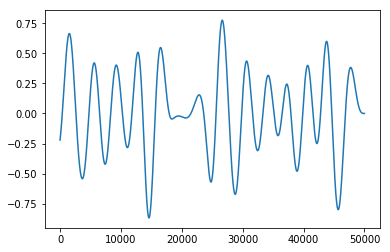

In [530]:
"""
Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9,Task10,Task11,Task12
131937,194227,316614,408845,498276,569670,673067,770846,850102,914459,1033507,1138836
rest,MATB_med,MATB_easy,MATB_hard,rest,MATB_hard,MATB_easy,MATB_med,rest,MATB_med,MATB_hard,MATB_easy
"""

onsets = [131937, 194227,316614,408845,498276,569670,673067,770846,850102,914459,1033507,1138836]
onset = onsets[1]
"""
get_eeg_features([
    eeg_a_raw[onset:onset+60000],
    eeg_b_raw[onset:onset+60000]
])
"""
get_resp_features(resp_raw[onset:onset+50000])

In [19]:
conditions_files = sorted(glob.glob('data/BIOPAC/*BIOPAC_conditions.csv'))
data_files = sorted(glob.glob('data/BIOPAC/aptima_*.txt'))

In [20]:
eeg_features = []
eda_features = []
ecg_features = []
resp_features = []

resp_idx = {"rest":1, "MATB_med":3, "MATB_easy": 2, "MATB_hard": 4}
response = []
for cond_f, data_f in zip(conditions_files, data_files):
    cond = pd.read_csv(cond_f)
    
    data = pd.read_csv(data_f, skiprows=15)
    data = data[1:]
    
    resp_raw = data["CH1"].values
    eda_raw = data["CH10"].values
    ecg_raw = data["CH13"].values
    eeg_a_raw = data["CH3"].values
    eeg_b_raw = data["CH16"].values
    
    for key in cond:
        if 'Task' in key:
            start = int(cond[key][0])
            duration = int(cond[key][1])
            end = start + duration
            
            res = str(cond[key][2])
            
            response.append(resp_idx[res])
            
            #resp_data = np.reshape(resp_filtered[start:end], (duration, 1))
            ecg_features.append(get_ecg_features(ecg_raw[start:end]))
            eda_features.append(get_eda_features(eda_raw[start:end]))
            resp_features.append(get_resp_features(resp_raw[start:end]))
            eeg_features.append(get_eeg_features([eeg_a_raw[start:end], eeg_b_raw[start:end]]))


NameError: name 'get_ecg_features' is not defined

In [533]:
rest = [1 if i == 1 else 0 for i in response]
easy = [1 if i == 2 else 0 for i in response]
med = [1 if i == 3 else 0 for i in response]
hard = [1 if i == 4 else 0 for i in response]

# RESP

##### easy

In [536]:
resp_rest = np.array([resp_features[i] for i in range(len(rest)) if rest[i] == 1 ])
resp_easy = np.array([resp_features[i] for i in range(len(easy)) if easy[i] == 1 ])

#step 1: calculate pair diffrernces
resp_diff_easy = - resp_rest + resp_easy

#step 2: mean_diff
mean_resp_diff_easy = np.mean(resp_diff_easy)

#step 3: standard deviation
std_resp_diff_easy = np.std(resp_diff_easy)

#step4: standard error:
se_resp_diff_easy = std_resp_diff_easy/np.sqrt(len(resp_easy))

# step 5: t-statistic
t_resp_easy = mean_resp_diff_easy/se_resp_diff_easy
p_resp_easy = scipy.stats.t.sf(np.abs(t_resp_easy), len(resp_rest)-1)*2
print(t_resp_easy, p_resp_easy)

1.2127575301959475 0.25981630832342095


##### med

In [537]:
resp_rest = np.array([resp_features[i] for i in range(len(rest)) if rest[i] == 1 ])
resp_med = np.array([resp_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
resp_diff_med = - resp_rest + resp_med

#step 2: mean_diff
mean_resp_diff_med = np.mean(resp_diff_med)

#step 3: standard deviation
std_resp_diff_med = np.std(resp_diff_med)

#step4: standard error:
se_resp_diff_med = std_resp_diff_med/np.sqrt(len(resp_med))

# step 5: t-statistic
t_resp_med = mean_resp_diff_med/se_resp_diff_med
p_resp_med = scipy.stats.t.sf(np.abs(t_resp_med), len(resp_rest)-1)*2
print(t_resp_med, p_resp_med)

-0.07033349636202149 0.9456546136655606


##### hard

In [538]:
resp_rest = np.array([resp_features[i] for i in range(len(rest)) if rest[i] == 1 ])
resp_hard = np.array([resp_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
resp_diff_hard = - resp_rest + resp_hard

#step 2: mean_diff
mean_resp_diff_hard = np.mean(resp_diff_hard)

#step 3: standard deviation
std_resp_diff_hard = np.std(resp_diff_hard)

#step4: standard error:
se_resp_diff_hard = std_resp_diff_hard/np.sqrt(len(resp_hard))

# step 5: t-statistic
t_resp_hard = mean_resp_diff_hard/se_resp_diff_hard
p_resp_hard = scipy.stats.t.sf(np.abs(t_resp_hard), len(resp_rest)-1)*2
print(t_resp_hard, p_resp_hard)

0.3637836414518582 0.7254459154862064


##### easy - med

In [539]:
resp_easy = np.array([resp_features[i] for i in range(len(easy)) if easy[i] == 1 ])
resp_med = np.array([resp_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
resp_diff_easy_med = - resp_med + resp_easy

#step 2: mean_diff
mean_resp_diff_easy_med = np.mean(resp_diff_easy_med)

#step 3: standard deviation
std_resp_diff_easy_med = np.std(resp_diff_easy_med)

#step4: standard error:
se_resp_diff_easy_med = std_resp_diff_easy_med/np.sqrt(len(resp_easy))

# step 5: t-statistic
t_resp_easy_med = mean_resp_diff_easy_med/se_resp_diff_easy_med
p_resp_easy_med = scipy.stats.t.sf(np.abs(t_resp_easy_med), len(resp_rest)-1)*2
print(t_resp_easy_med, p_resp_easy_med)

1.2973544792898493 0.23066870375204046


##### easy-hard

In [540]:
resp_easy = np.array([resp_features[i] for i in range(len(easy)) if easy[i] == 1 ])
resp_hard = np.array([resp_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
resp_diff_easy_hard = - resp_hard + resp_easy

#step 2: mean_diff
mean_resp_diff_easy_hard = np.mean(resp_diff_easy_hard)

#step 3: standard deviation
std_resp_diff_easy_hard = np.std(resp_diff_easy_hard)

#step4: standard error:
se_resp_diff_easy_hard = std_resp_diff_easy_hard/np.sqrt(len(resp_easy))

# step 5: t-statistic
t_resp_easy_hard = mean_resp_diff_easy_hard/se_resp_diff_easy_hard
p_resp_easy_hard = scipy.stats.t.sf(np.abs(t_resp_easy_hard), len(resp_rest)-1)*2
print(t_resp_easy_hard, p_resp_easy_hard)

1.288549137437755 0.2335679680343891


##### med-hard

In [541]:
resp_med = np.array([resp_features[i] for i in range(len(med)) if med[i] == 1 ])
resp_hard = np.array([resp_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
resp_diff_med_hard = - resp_hard + resp_med

#step 2: mean_diff
mean_resp_diff_med_hard = np.mean(resp_diff_med_hard)

#step 3: standard deviation
std_resp_diff_med_hard = np.std(resp_diff_med_hard)

#step4: standard error:
se_resp_diff_med_hard = std_resp_diff_med_hard/np.sqrt(len(resp_med))

# step 5: t-statistic
t_resp_med_hard = mean_resp_diff_med_hard/se_resp_diff_med_hard
p_resp_med_hard = scipy.stats.t.sf(np.abs(t_resp_med_hard), len(resp_rest)-1)*2
print(t_resp_med_hard, p_resp_med_hard)

-0.48860506359874084 0.6382330111165673


In [542]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_resp_diff_easy, -mean_resp_diff_med,mean_resp_diff_hard, mean_resp_diff_easy_med, mean_resp_diff_easy_hard, -mean_resp_diff_med_hard],
    name='Avg. Respiration Rate',
    error_y=dict(
        type='data',
        array=[se_resp_diff_easy, se_resp_diff_med, se_resp_diff_hard, se_resp_diff_easy_med, se_resp_diff_easy_hard, se_resp_diff_med_hard],
        visible=True
    )
)
data = [trace1]
layout = go.Layout(
    showlegend=True,
    barmode='group',
    legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


# ECG

In [543]:
ecg_features_std=ecg_features - np.mean(ecg_features, axis=0)
ecg_features_std/=np.std(ecg_features, axis=0)

##### easy

In [545]:
ecg_rest = np.array([ecg_features[i] for i in range(len(rest)) if rest[i] == 1 ])
ecg_easy = np.array([ecg_features[i] for i in range(len(easy)) if easy[i] == 1 ])

#step 1: calculate pair diffrernces
ecg_diff_easy = - ecg_rest + ecg_easy

#step 2: mean_diff
mean_ecg_diff_easy = np.mean(ecg_diff_easy, axis=0)

#step 3: standard deviation
std_ecg_diff_easy = np.std(ecg_diff_easy, axis=0)
#step4: standard error:
se_ecg_diff_easy = std_ecg_diff_easy/np.sqrt(len(ecg_easy))

# step 5: t-statistic
t_ecg_easy = mean_ecg_diff_easy/se_ecg_diff_easy
p_ecg_easy = scipy.stats.t.sf(np.abs(t_ecg_easy), len(ecg_rest)-1)*2
print(t_ecg_easy, p_ecg_easy)

[ 0.47977574 -1.07653157] [0.64422928 0.31307954]


##### medium

In [546]:
ecg_rest = np.array([ecg_features[i] for i in range(len(rest)) if rest[i] == 1 ])
ecg_med = np.array([ecg_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
ecg_diff_med = - ecg_rest + ecg_med

#step 2: mean_diff
mean_ecg_diff_med = np.mean(ecg_diff_med, axis=0)

#step 3: standard deviation
std_ecg_diff_med = np.std(ecg_diff_med, axis=0)
#step4: standard error:
se_ecg_diff_med = std_ecg_diff_med/np.sqrt(len(ecg_med))

# step 5: t-statistic
t_ecg_med = mean_ecg_diff_med/se_ecg_diff_med
p_ecg_med = scipy.stats.t.sf(np.abs(t_ecg_med), len(ecg_rest)-1)*2
print(t_ecg_med, p_ecg_med)

[ 1.30519598 -1.16309504] [0.22811258 0.27830764]


##### hard

In [547]:
ecg_rest = np.array([ecg_features[i] for i in range(len(rest)) if rest[i] == 1 ])
ecg_hard = np.array([ecg_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
ecg_diff_hard = - ecg_rest + ecg_hard

#step 2: mean_diff
mean_ecg_diff_hard = np.mean(ecg_diff_hard, axis=0)

#step 3: standard deviation
std_ecg_diff_hard = np.std(ecg_diff_hard, axis=0)
#step4: standard error:
se_ecg_diff_hard = std_ecg_diff_hard/np.sqrt(len(ecg_hard))

# step 5: t-statistic
t_ecg_hard = mean_ecg_diff_hard/se_ecg_diff_hard
p_ecg_hard = scipy.stats.t.sf(np.abs(t_ecg_hard), len(ecg_rest)-1)*2
print(t_ecg_hard, p_ecg_hard)

[ 0.72403328 -1.41058018] [0.48967392 0.19604739]


##### easy - med

In [548]:
ecg_easy = np.array([ecg_features[i] for i in range(len(easy)) if easy[i] == 1 ])
ecg_med = np.array([ecg_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
ecg_diff_easy_med = - ecg_med + ecg_easy

#step 2: mean_diff
mean_ecg_diff_easy_med = np.mean(ecg_diff_easy_med, axis=0)

#step 3: standard deviation
std_ecg_diff_easy_med = np.std(ecg_diff_easy_med, axis=0)

#step4: standard error:
se_ecg_diff_easy_med = std_ecg_diff_easy_med/np.sqrt(len(ecg_easy))

# step 5: t-statistic
t_ecg_easy_med = mean_ecg_diff_easy_med/se_ecg_diff_easy_med
p_ecg_easy_med = scipy.stats.t.sf(np.abs(t_ecg_easy_med), len(ecg_rest)-1)*2
print(t_ecg_easy_med, p_ecg_easy_med)

[-0.88693057 -0.00630504] [0.40099252 0.99512373]


##### easy-hard

In [549]:
ecg_easy = np.array([ecg_features[i] for i in range(len(easy)) if easy[i] == 1 ])
ecg_hard = np.array([ecg_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
ecg_diff_easy_hard = - ecg_hard + ecg_easy

#step 2: mean_diff
mean_ecg_diff_easy_hard = np.mean(ecg_diff_easy_hard, axis=0)

#step 3: standard deviation
std_ecg_diff_easy_hard = np.std(ecg_diff_easy_hard, axis=0)

#step4: standard error:
se_ecg_diff_easy_hard = std_ecg_diff_easy_hard/np.sqrt(len(ecg_easy))

# step 5: t-statistic
t_ecg_easy_hard = mean_ecg_diff_easy_hard/se_ecg_diff_easy_hard
p_ecg_easy_hard = scipy.stats.t.sf(np.abs(t_ecg_easy_hard), len(ecg_rest)-1)*2
print(t_ecg_easy_hard, p_ecg_easy_hard)

[-0.16023266  0.12481473] [0.8766698 0.9037496]


##### med-hard

In [550]:
ecg_med = np.array([ecg_features[i] for i in range(len(med)) if med[i] == 1 ])
ecg_hard = np.array([ecg_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
ecg_diff_med_hard = - ecg_hard + ecg_med

#step 2: mean_diff
mean_ecg_diff_med_hard = np.mean(ecg_diff_med_hard, axis=0)

#step 3: standard deviation
std_ecg_diff_med_hard = np.std(ecg_diff_med_hard, axis=0)

#step4: standard error:
se_ecg_diff_med_hard = std_ecg_diff_med_hard/np.sqrt(len(ecg_med))

# step 5: t-statistic
t_ecg_med_hard = mean_ecg_diff_med_hard/se_ecg_diff_med_hard
p_ecg_med_hard = scipy.stats.t.sf(np.abs(t_ecg_med_hard), len(ecg_rest)-1)*2
print(t_ecg_med_hard, p_ecg_med_hard)

[0.83617003 0.13859718] [0.42732686 0.89319376]


In [551]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_ecg_diff_easy[0], mean_ecg_diff_med[0], mean_ecg_diff_hard[0], -mean_ecg_diff_easy_med[0], -mean_ecg_diff_easy_hard[0], mean_ecg_diff_med_hard[0]],
    name='meanRR',
    error_y=dict(
        type='data',
        array=[se_ecg_diff_easy[0], se_ecg_diff_med[0], se_ecg_diff_hard[0], se_ecg_diff_easy_med[0], se_ecg_diff_easy_hard[0], se_ecg_diff_med_hard[0]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_ecg_diff_easy[1], -mean_ecg_diff_med[1], -mean_ecg_diff_hard[1], mean_ecg_diff_easy_med[1], mean_ecg_diff_easy_hard[1], mean_ecg_diff_med_hard[1]],
    name='meanHR',
    error_y=dict(
        type='data',
        array=[-se_ecg_diff_easy[1], -se_ecg_diff_med[1], -se_ecg_diff_hard[1], se_ecg_diff_easy_med[1], se_ecg_diff_easy_hard[1], se_ecg_diff_med_hard[1]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


# EEG

##### easy

In [552]:
eeg_rest = np.array([eeg_features[i] for i in range(len(rest)) if rest[i] == 1 ])
eeg_easy = np.array([eeg_features[i] for i in range(len(easy)) if easy[i] == 1 ])

#step 1: calculate pair diffrernces
eeg_diff_easy = - eeg_rest + eeg_easy

#step 2: mean_diff
mean_eeg_diff_easy = np.mean(eeg_diff_easy, axis=0)

#step 3: standard deviation
std_eeg_diff_easy = np.std(eeg_diff_easy, axis=0)
#step4: standard error:
se_eeg_diff_easy = std_eeg_diff_easy/np.sqrt(len(eeg_easy))

# step 5: t-statistic
t_eeg_easy = mean_eeg_diff_easy/se_eeg_diff_easy
p_eeg_easy = scipy.stats.t.sf(np.abs(t_eeg_easy), len(eeg_rest)-1)*2
print(t_eeg_easy, p_eeg_easy)

[-2.57634385 -2.5702453  -2.21836698 -2.223064   -0.49823812 -0.52354605
  0.37938936  0.38201891] [0.0328023  0.03311493 0.05732795 0.05690945 0.63172308 0.61478332
 0.71427111 0.71239528]


##### medium

In [553]:
eeg_rest = np.array([eeg_features[i] for i in range(len(rest)) if rest[i] == 1 ])
eeg_med = np.array([eeg_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
eeg_diff_med = - eeg_rest + eeg_med

#step 2: mean_diff
mean_eeg_diff_med = np.mean(eeg_diff_med, axis=0)

#step 3: standard deviation
std_eeg_diff_med = np.std(eeg_diff_med, axis=0)
#step4: standard error:
se_eeg_diff_med = std_eeg_diff_med/np.sqrt(len(eeg_med))

# step 5: t-statistic
t_eeg_med = mean_eeg_diff_med/se_eeg_diff_med
p_eeg_med = scipy.stats.t.sf(np.abs(t_eeg_med), len(eeg_rest)-1)*2
print(t_eeg_med, p_eeg_med)

[-0.08551155 -0.08645988 -0.32641306 -0.32250765  0.31798203  0.32060595
  0.27842289  0.28714203] [0.93395607 0.93322568 0.7524874  0.75533527 0.75864039 0.75672345
 0.7877488  0.78130062]


##### hard

In [554]:
eeg_rest = np.array([eeg_features[i] for i in range(len(rest)) if rest[i] == 1 ])
eeg_hard = np.array([eeg_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
eeg_diff_hard = - eeg_rest + eeg_hard

#step 2: mean_diff
mean_eeg_diff_hard = np.mean(eeg_diff_hard, axis=0)

#step 3: standard deviation
std_eeg_diff_hard = np.std(eeg_diff_hard, axis=0)
#step4: standard error:
se_eeg_diff_hard = std_eeg_diff_hard/np.sqrt(len(eeg_hard))

# step 5: t-statistic
t_eeg_hard = mean_eeg_diff_hard/se_eeg_diff_hard
p_eeg_hard = scipy.stats.t.sf(np.abs(t_eeg_hard), len(eeg_rest)-1)*2
print(t_eeg_hard, p_eeg_hard)

[-0.11890567 -0.10861038  0.10506229  0.10300216  0.18424418  0.17701167
 -0.26165966 -0.25819561] [0.90828166 0.91618628 0.91891282 0.92049646 0.85840656 0.86389864
 0.80019458 0.80277417]


##### easy - med

In [555]:
eeg_easy = np.array([eeg_features[i] for i in range(len(easy)) if easy[i] == 1 ])
eeg_med = np.array([eeg_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
eeg_diff_easy_med = - eeg_med + eeg_easy

#step 2: mean_diff
mean_eeg_diff_easy_med = np.mean(eeg_diff_easy_med, axis=0)

#step 3: standard deviation
std_eeg_diff_easy_med = np.std(eeg_diff_easy_med, axis=0)

#step4: standard error:
se_eeg_diff_easy_med = std_eeg_diff_easy_med/np.sqrt(len(eeg_easy))

# step 5: t-statistic
t_eeg_easy_med = mean_eeg_diff_easy_med/se_eeg_diff_easy_med
p_eeg_easy_med = scipy.stats.t.sf(np.abs(t_eeg_easy_med), len(eeg_rest)-1)*2
print(t_eeg_easy_med, p_eeg_easy_med)

[-1.22415358 -1.22079481 -1.21423878 -1.20740578 -1.04566606 -1.08402478
  0.18898447  0.18051758] [0.25571926 0.25692118 0.25928072 0.26175901 0.32627852 0.30993937
 0.85481139 0.86123539]


##### easy-hard

In [556]:
eeg_easy = np.array([eeg_features[i] for i in range(len(easy)) if easy[i] == 1 ])
eeg_hard = np.array([eeg_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
eeg_diff_easy_hard = - eeg_hard + eeg_easy

#step 2: mean_diff
mean_eeg_diff_easy_hard = np.mean(eeg_diff_easy_hard, axis=0)

#step 3: standard deviation
std_eeg_diff_easy_hard = np.std(eeg_diff_easy_hard, axis=0)

#step4: standard error:
se_eeg_diff_easy_hard = std_eeg_diff_easy_hard/np.sqrt(len(eeg_easy))

# step 5: t-statistic
t_eeg_easy_hard = mean_eeg_diff_easy_hard/se_eeg_diff_easy_hard
p_eeg_easy_hard = scipy.stats.t.sf(np.abs(t_eeg_easy_hard), len(eeg_rest)-1)*2
print(t_eeg_easy_hard, p_eeg_easy_hard)

[-2.83550977 -2.822554   -1.97194107 -1.96393822 -0.43508864 -0.4389144
  0.90845045  0.90458561] [0.02196318 0.02240559 0.08409078 0.08513807 0.67499714 0.67233632
 0.39018621 0.39211124]


##### med-hard

In [557]:
eeg_med = np.array([eeg_features[i] for i in range(len(med)) if med[i] == 1 ])
eeg_hard = np.array([eeg_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
eeg_diff_med_hard = - eeg_hard + eeg_med

#step 2: mean_diff
mean_eeg_diff_med_hard = np.mean(eeg_diff_med_hard, axis=0)

#step 3: standard deviation
std_eeg_diff_med_hard = np.std(eeg_diff_med_hard, axis=0)

#step4: standard error:
se_eeg_diff_med_hard = std_eeg_diff_med_hard/np.sqrt(len(eeg_med))

# step 5: t-statistic
t_eeg_med_hard = mean_eeg_diff_med_hard/se_eeg_diff_med_hard
p_eeg_med_hard = scipy.stats.t.sf(np.abs(t_eeg_med_hard), len(eeg_rest)-1)*2
print(t_eeg_med_hard, p_eeg_med_hard)

[-0.00122563 -0.01066933 -0.51803095 -0.50892174 -0.01624553 -0.00469363
  0.65494809  0.65984739] [0.9990521  0.99174854 0.61845444 0.62454296 0.98743636 0.99636997
 0.53087775 0.52788745]


In [558]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eeg_diff_easy[0], -mean_eeg_diff_med[0], -mean_eeg_diff_hard[0], -mean_eeg_diff_easy_med[0], -mean_eeg_diff_easy_hard[0], mean_eeg_diff_med_hard[0]],
    name='mean theta CH1',
    error_y=dict(
        type='data',
        array=[-se_eeg_diff_easy[0], -se_eeg_diff_med[0], -se_eeg_diff_hard[0], se_eeg_diff_easy_med[0], se_eeg_diff_easy_hard[0], se_eeg_diff_med_hard[0]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eeg_diff_easy[1], -mean_eeg_diff_med[1], -mean_eeg_diff_hard[1], -mean_eeg_diff_easy_med[1], -mean_eeg_diff_easy_hard[1], -mean_eeg_diff_med_hard[1]],
    name='mean theta CH2',
    error_y=dict(
        type='data',
        array=[-se_eeg_diff_easy[1], -se_eeg_diff_med[1], -se_eeg_diff_hard[1], -se_eeg_diff_easy_med[1], -se_eeg_diff_easy_hard[1], -se_eeg_diff_med_hard[1]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


In [559]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eeg_diff_easy[2], -mean_eeg_diff_med[2], mean_eeg_diff_hard[2], -mean_eeg_diff_easy_med[2], -mean_eeg_diff_easy_hard[2], -mean_eeg_diff_med_hard[2]],
    name='mean alpha CH1',
    error_y=dict(
        type='data',
        array=[-se_eeg_diff_easy[2], -se_eeg_diff_med[2], se_eeg_diff_hard[2], se_eeg_diff_easy_med[2], se_eeg_diff_easy_hard[2], -se_eeg_diff_med_hard[2]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eeg_diff_easy[3], -mean_eeg_diff_med[3], mean_eeg_diff_hard[3], -mean_eeg_diff_easy_med[3], -mean_eeg_diff_easy_hard[3], -mean_eeg_diff_med_hard[3]],
    name='mean alpha CH2',
    error_y=dict(
        type='data',
        array=[-se_eeg_diff_easy[3], -se_eeg_diff_med[3], se_eeg_diff_hard[3], se_eeg_diff_easy_med[3], se_eeg_diff_easy_hard[3], -se_eeg_diff_med_hard[3]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


In [560]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eeg_diff_easy[4], mean_eeg_diff_med[4], mean_eeg_diff_hard[4], -mean_eeg_diff_easy_med[4], -mean_eeg_diff_easy_hard[4], -mean_eeg_diff_med_hard[4]],
    name='mean beta CH1',
    error_y=dict(
        type='data',
        array=[-se_eeg_diff_easy[4], se_eeg_diff_med[4], se_eeg_diff_hard[4], se_eeg_diff_easy_med[4], se_eeg_diff_easy_hard[4], -se_eeg_diff_med_hard[4]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eeg_diff_easy[5], mean_eeg_diff_med[5], mean_eeg_diff_hard[5], -mean_eeg_diff_easy_med[5], -mean_eeg_diff_easy_hard[5], -mean_eeg_diff_med_hard[5]],
    name='mean beta CH2',
    error_y=dict(
        type='data',
        array=[-se_eeg_diff_easy[5], se_eeg_diff_med[5], se_eeg_diff_hard[5], se_eeg_diff_easy_med[5], se_eeg_diff_easy_hard[5], -se_eeg_diff_med_hard[5]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


In [561]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_eeg_diff_easy[6], mean_eeg_diff_med[6], -mean_eeg_diff_hard[6], mean_eeg_diff_easy_med[6], mean_eeg_diff_easy_hard[6], mean_eeg_diff_med_hard[6]],
    name='mean gamma CH1',
    error_y=dict(
        type='data',
        array=[se_eeg_diff_easy[5], se_eeg_diff_med[5], -se_eeg_diff_hard[5], -se_eeg_diff_easy_med[5], -se_eeg_diff_easy_hard[5], se_eeg_diff_med_hard[5]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_eeg_diff_easy[7], mean_eeg_diff_med[7], -mean_eeg_diff_hard[7], mean_eeg_diff_easy_med[7], mean_eeg_diff_easy_hard[7], mean_eeg_diff_med_hard[7]],
    name='mean gamma CH2',
    error_y=dict(
        type='data',
        array=[se_eeg_diff_easy[5], se_eeg_diff_med[5], -se_eeg_diff_hard[5], -se_eeg_diff_easy_med[5], -se_eeg_diff_easy_hard[5], se_eeg_diff_med_hard[5]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


# EDA

##### easy

In [562]:
eda_rest = np.array([eda_features[i] for i in range(len(rest)) if rest[i] == 1 ])
eda_easy = np.array([eda_features[i] for i in range(len(easy)) if easy[i] == 1 ])

#step 1: calculate pair diffrernces
eda_diff_easy = - eda_rest + eda_easy

#step 2: mean_diff
mean_eda_diff_easy = np.mean(eda_diff_easy, axis=0)

#step 3: standard deviation
std_eda_diff_easy = np.std(eda_diff_easy, axis=0)
#step4: standard error:
se_eda_diff_easy = std_eda_diff_easy/np.sqrt(len(eda_easy))

# step 5: t-statistic
t_eda_easy = mean_eda_diff_easy/se_eda_diff_easy
p_eda_easy = scipy.stats.t.sf(np.abs(t_eda_easy), len(eda_rest)-1)*2
print(t_eda_easy, p_eda_easy)

[-1.98347485 -0.37148111] [0.08260326 0.71992503]


##### medium

In [563]:
eda_rest = np.array([eda_features[i] for i in range(len(rest)) if rest[i] == 1 ])
eda_med = np.array([eda_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
eda_diff_med = - eda_rest + eda_med

#step 2: mean_diff
mean_eda_diff_med = np.mean(eda_diff_med, axis=0)

#step 3: standard deviation
std_eda_diff_med = np.std(eda_diff_med, axis=0)
#step4: standard error:
se_eda_diff_med = std_eda_diff_med/np.sqrt(len(eda_med))

# step 5: t-statistic
t_eda_med = mean_eda_diff_med/se_eda_diff_med
p_eda_med = scipy.stats.t.sf(np.abs(t_eda_med), len(eda_rest)-1)*2
print(t_eda_med, p_eda_med)

[0.30807609 0.45780969] [0.76589318 0.65926712]


##### hard

In [564]:
eda_rest = np.array([eda_features[i] for i in range(len(rest)) if rest[i] == 1 ])
eda_hard = np.array([eda_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
eda_diff_hard = - eda_rest + eda_hard

#step 2: mean_diff
mean_eda_diff_hard = np.mean(eda_diff_hard, axis=0)

#step 3: standard deviation
std_eda_diff_hard = np.std(eda_diff_hard, axis=0)
#step4: standard error:
se_eda_diff_hard = std_eda_diff_hard/np.sqrt(len(eda_hard))

# step 5: t-statistic
t_eda_hard = mean_eda_diff_hard/se_eda_diff_hard
p_eda_hard = scipy.stats.t.sf(np.abs(t_eda_hard), len(eda_rest)-1)*2
print(t_eda_hard, p_eda_hard)

[ 0.01483    -0.03703135] [0.98853098 0.97136739]


##### easy - med

In [565]:
eda_easy = np.array([eda_features[i] for i in range(len(easy)) if easy[i] == 1 ])
eda_med = np.array([eda_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
eda_diff_easy_med = - eda_med + eda_easy

#step 2: mean_diff
mean_eda_diff_easy_med = np.mean(eda_diff_easy_med, axis=0)

#step 3: standard deviation
std_eda_diff_easy_med = np.std(eda_diff_easy_med, axis=0)

#step4: standard error:
se_eda_diff_easy_med = std_eda_diff_easy_med/np.sqrt(len(eda_easy))

# step 5: t-statistic
t_eda_easy_med = mean_eda_diff_easy_med/se_eda_diff_easy_med
p_eda_easy_med = scipy.stats.t.sf(np.abs(t_eda_easy_med), len(eda_rest)-1)*2
print(t_eda_easy_med, p_eda_easy_med)

[-2.62103734 -1.17657127] [0.03060113 0.27318656]


##### easy-hard

In [566]:
eda_easy = np.array([eda_features[i] for i in range(len(easy)) if easy[i] == 1 ])
eda_hard = np.array([eda_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
eda_diff_easy_hard = - eda_hard + eda_easy

#step 2: mean_diff
mean_eda_diff_easy_hard = np.mean(eda_diff_easy_hard, axis=0)

#step 3: standard deviation
std_eda_diff_easy_hard = np.std(eda_diff_easy_hard, axis=0)

#step4: standard error:
se_eda_diff_easy_hard = std_eda_diff_easy_hard/np.sqrt(len(eda_easy))

# step 5: t-statistic
t_eda_easy_hard = mean_eda_diff_easy_hard/se_eda_diff_easy_hard
p_eda_easy_hard = scipy.stats.t.sf(np.abs(t_eda_easy_hard), len(eda_rest)-1)*2
print(t_eda_easy_hard, p_eda_easy_hard)

[-1.34289754 -0.48799127] [0.21615761 0.63864895]


##### med-hard

In [567]:
eda_med = np.array([eda_features[i] for i in range(len(med)) if med[i] == 1 ])
eda_hard = np.array([eda_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
eda_diff_med_hard = - eda_hard + eda_med

#step 2: mean_diff
mean_eda_diff_med_hard = np.mean(eda_diff_med_hard, axis=0)

#step 3: standard deviation
std_eda_diff_med_hard = np.std(eda_diff_med_hard, axis=0)

#step4: standard error:
se_eda_diff_med_hard = std_eda_diff_med_hard/np.sqrt(len(eda_med))

# step 5: t-statistic
t_eda_med_hard = mean_eda_diff_med_hard/se_eda_diff_med_hard
p_eda_med_hard = scipy.stats.t.sf(np.abs(t_eda_med_hard), len(eda_rest)-1)*2
print(t_eda_med_hard, p_eda_med_hard)

[0.20124493 0.75993482] [0.84552966 0.46909404]


In [568]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eda_diff_easy[0], mean_eda_diff_med[0], mean_eda_diff_hard[0], -mean_eda_diff_easy_med[0], -mean_eda_diff_easy_hard[0], mean_eda_diff_med_hard[0]],
    name='meanSCR',
    error_y=dict(
        type='data',
        array=[-se_eda_diff_easy[0], se_eda_diff_med[0], se_eda_diff_hard[0], -se_eda_diff_easy_med[0], -se_eda_diff_easy_hard[0], se_eda_diff_med_hard[0]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_eda_diff_easy[1], mean_eda_diff_med[1], mean_eda_diff_hard[1], -mean_eda_diff_easy_med[1], -mean_eda_diff_easy_hard[1], mean_eda_diff_med_hard[1]],
    name='meanSCR rise time ',
    error_y=dict(
        type='data',
        array=[-se_eda_diff_easy[1], se_eda_diff_med[1], se_eda_diff_hard[1], -se_eda_diff_easy_med[1], -se_eda_diff_easy_hard[1], se_eda_diff_med_hard[1]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


# fNIRS

In [48]:
def get_fnirs_features(oxy, dxy):
    # oxy first half, oxy second half, dxy first half, dxy second half
    return np.array([
        np.mean(oxy[:300]),
        np.mean(oxy[300:]),
        np.mean(dxy[:300]),
        np.mean(dxy[300:])
        
    ])

In [49]:
conditions_files = sorted(glob.glob('data/plux/*Plux_conditions.csv'))
data_files = sorted(glob.glob('data/plux/aptima_*.txt'))

In [50]:
fnirs_data = {}

for data_f in data_files:
    fnirs_raw = {'CH9': [], 'CH10': []}
    fnirs_data[data_f] = None
    
    data = open(data_f, 'r')
    
    for line in data:
        if '#' in line:
            continue
        else:
            val = line.split("\t")
            fnirs_raw['CH9'].append(int(val[2]))
            fnirs_raw['CH10'].append(int(val[3]))
    fnirs_data[data_f] = fnirs_raw
    df = pd.DataFrame.from_dict(fnirs_raw)
    df.to_csv(data_f+'.csv')
    

In [51]:
mat_files = sorted(glob.glob('data/plux/aptima_*.mat'))
from scipy.io import loadmat

In [52]:
response_fnirs = []
fnirs_features = []
fnirs_data = []
for data_mat, cond_f in zip(mat_files, conditions_files):
    m_data = loadmat(data_mat)
    dxy_data = m_data['nirs_data'][0][0][0]
    oxy_data = m_data['nirs_data'][0][0][1]
    
    cond = pd.read_csv(cond_f)
    for key in cond:
        if 'Task' in key:
            start = int(cond[key][0])
            duration = int(cond[key][1])*10
            end = start + duration
            
            res = str(cond[key][2])
            response_fnirs.append(resp_idx[res])
            fnirs_data.append([oxy_data[start:end, :], dxy_data[start:end, :]])
            fnirs_features.append(get_fnirs_features(oxy_data[start:end, :], dxy_data[start:end, :]))

In [53]:
rest = [1 if i == 1 else 0 for i in response_fnirs]
easy = [1 if i == 2 else 0 for i in response_fnirs]
med = [1 if i == 3 else 0 for i in response_fnirs]
hard = [1 if i == 4 else 0 for i in response_fnirs]

##### easy

In [54]:
fnirs_rest = np.array([fnirs_features[i] for i in range(len(rest)) if rest[i] == 1 ])
fnirs_easy = np.array([fnirs_features[i] for i in range(len(easy)) if easy[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_easy = - fnirs_rest + fnirs_easy

#step 2: mean_diff
mean_fnirs_diff_easy = np.mean(fnirs_diff_easy, axis=0)

#step 3: standard deviation
std_fnirs_diff_easy = np.std(fnirs_diff_easy, axis=0)
#step4: standard error:
se_fnirs_diff_easy = std_fnirs_diff_easy/len(fnirs_easy)

# step 5: t-statistic
t_fnirs_easy = mean_fnirs_diff_easy/se_fnirs_diff_easy
p_fnirs_easy = scipy.stats.t.sf(np.abs(t_fnirs_easy), len(fnirs_rest)-1)
print(t_fnirs_easy, p_fnirs_easy)

[ 6.59181181 -4.84678218 -3.28899835 -1.32014165] [8.54195746e-05 6.38533385e-04 5.51926261e-03 1.11653722e-01]


##### med

In [55]:
fnirs_rest = np.array([fnirs_features[i] for i in range(len(rest)) if rest[i] == 1 ])
fnirs_med = np.array([fnirs_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_med = - fnirs_rest + fnirs_med

#step 2: mean_diff
mean_fnirs_diff_med = np.mean(fnirs_diff_med, axis=0)

#step 3: standard deviation
std_fnirs_diff_med = np.std(fnirs_diff_med, axis=0)
#step4: standard error:
se_fnirs_diff_med = std_fnirs_diff_med/len(fnirs_med)

# step 5: t-statistic
t_fnirs_med = mean_fnirs_diff_med/se_fnirs_diff_med
p_fnirs_med = scipy.stats.t.sf(np.abs(t_fnirs_med), len(fnirs_rest)-1)*2
print(t_fnirs_med, p_fnirs_med)

[ 6.55802061 -7.50837859 -3.52740427  1.54973817] [1.76981013e-04 6.87302574e-05 7.76139865e-03 1.59799145e-01]


##### hard

In [56]:
fnirs_rest = np.array([fnirs_features[i] for i in range(len(rest)) if rest[i] == 1 ])
fnirs_hard = np.array([fnirs_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_hard = - fnirs_rest + fnirs_hard

#step 2: mean_diff
mean_fnirs_diff_hard = np.mean(fnirs_diff_hard, axis=0)

#step 3: standard deviation
std_fnirs_diff_hard = np.var(fnirs_diff_hard, axis=0)
#step4: standard error:
se_fnirs_diff_hard = std_fnirs_diff_hard/len(fnirs_hard)

# step 5: t-statistic
t_fnirs_hard = mean_fnirs_diff_hard/np.sqrt(se_fnirs_diff_hard)
p_fnirs_hard = scipy.stats.t.sf(np.abs(t_fnirs_hard), len(fnirs_rest)-1)*2
print(t_fnirs_hard, p_fnirs_hard)

[ 1.84383429 -0.44786939 -0.97378263  0.00875988] [0.10244118 0.66612733 0.35868478 0.99322523]


##### easy - med

In [57]:
fnirs_easy = np.array([fnirs_features[i] for i in range(len(easy)) if easy[i] == 1 ])
fnirs_med = np.array([fnirs_features[i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_easy_med = - fnirs_med + fnirs_easy

#step 2: mean_diff
mean_fnirs_diff_easy_med = np.mean(fnirs_diff_easy_med, axis=0)

#step 3: standard deviation
std_fnirs_diff_easy_med = np.std(fnirs_diff_easy_med, axis=0)

#step4: standard error:
se_fnirs_diff_easy_med = std_fnirs_diff_easy_med/len(fnirs_easy)

# step 5: t-statistic
t_fnirs_easy_med = mean_fnirs_diff_easy_med/se_fnirs_diff_easy_med
p_fnirs_easy_med = scipy.stats.t.sf(np.abs(t_fnirs_easy_med), len(fnirs_rest)-1)*2
print(t_fnirs_easy_med, p_fnirs_easy_med)

[-0.38739403  0.04112243  0.56512757 -2.04231546] [0.70856733 0.96820607 0.58748053 0.07540236]


##### easy-hard

In [58]:
fnirs_easy = np.array([fnirs_features[i] for i in range(len(easy)) if easy[i] == 1 ])
fnirs_hard = np.array([fnirs_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_easy_hard = - fnirs_hard + fnirs_easy

#step 2: mean_diff
mean_fnirs_diff_easy_hard = np.mean(fnirs_diff_easy_hard, axis=0)

#step 3: standard deviation
std_fnirs_diff_easy_hard = np.std(fnirs_diff_easy_hard, axis=0)

#step4: standard error:
se_fnirs_diff_easy_hard = std_fnirs_diff_easy_hard/len(fnirs_easy)

# step 5: t-statistic
t_fnirs_easy_hard = mean_fnirs_diff_easy_hard/se_fnirs_diff_easy_hard
p_fnirs_easy_hard = scipy.stats.t.sf(np.abs(t_fnirs_easy_hard), len(fnirs_rest)-1)*2
print(t_fnirs_easy_hard, p_fnirs_easy_hard)

[ 2.18888872 -4.21869309 -0.99879987 -1.51566   ] [0.0600249  0.00292102 0.34714015 0.16807356]


##### med-hard

In [59]:
fnirs_med = np.array([fnirs_features[i] for i in range(len(med)) if med[i] == 1 ])
fnirs_hard = np.array([fnirs_features[i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_med_hard = - fnirs_hard + fnirs_med

#step 2: mean_diff
mean_fnirs_diff_med_hard = np.mean(fnirs_diff_med_hard, axis=0)

#step 3: standard deviation
std_fnirs_diff_med_hard = np.std(fnirs_diff_med_hard, axis=0)

#step4: standard error:
se_fnirs_diff_med_hard = std_fnirs_diff_med_hard/len(fnirs_med)

# step 5: t-statistic
t_fnirs_med_hard = mean_fnirs_diff_med_hard/se_fnirs_diff_med_hard
p_fnirs_med_hard = scipy.stats.t.sf(np.abs(t_fnirs_med_hard), len(fnirs_rest)-1)*2
print(t_fnirs_med_hard, p_fnirs_med_hard)

[ 1.70601424 -2.44704757 -1.59491528  1.3498654 ] [0.12639668 0.04012105 0.14939744 0.21400804]


In [60]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_fnirs_diff_easy[0], mean_fnirs_diff_med[0], mean_fnirs_diff_hard[0], -mean_fnirs_diff_easy_med[0], mean_fnirs_diff_easy_hard[0], mean_fnirs_diff_med_hard[0]],
    name='oxy first half',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[0], se_fnirs_diff_med[0], se_fnirs_diff_hard[0], se_fnirs_diff_easy_med[0], se_fnirs_diff_easy_hard[0], se_fnirs_diff_med_hard[0]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_fnirs_diff_easy[1], -mean_fnirs_diff_med[1], -mean_fnirs_diff_hard[1], mean_fnirs_diff_easy_med[1], -mean_fnirs_diff_easy_hard[1], -mean_fnirs_diff_med_hard[1]],
    name='oxy second half ',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[1], se_fnirs_diff_med[1], se_fnirs_diff_hard[1], se_fnirs_diff_easy_med[1], se_fnirs_diff_easy_hard[1], se_fnirs_diff_med_hard[1]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


In [61]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_fnirs_diff_easy[2], -mean_fnirs_diff_med[2], -mean_fnirs_diff_hard[2], mean_fnirs_diff_easy_med[2], -mean_fnirs_diff_easy_hard[2], -mean_fnirs_diff_med_hard[2]],
    name='dxy first half',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[2], se_fnirs_diff_med[2], se_fnirs_diff_hard[2], se_fnirs_diff_easy_med[2], se_fnirs_diff_easy_hard[2], se_fnirs_diff_med_hard[2]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_fnirs_diff_easy[3], mean_fnirs_diff_med[3], -mean_fnirs_diff_hard[3],  -mean_fnirs_diff_easy_med[3], -mean_fnirs_diff_easy_hard[3], mean_fnirs_diff_med_hard[3]],
    name='dxy second half ',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[3], se_fnirs_diff_med[3], se_fnirs_diff_hard[3], se_fnirs_diff_easy_med[3], se_fnirs_diff_easy_hard[3], se_fnirs_diff_med_hard[3]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


# fNIRS Pilot 2.0

In [3]:
conditions_files = sorted(glob.glob('data/plux_2.0_data/aptima*conditions.csv'))
data_files = sorted(glob.glob('data/plux_2.0_data/pilot_explorer_cleaned_*.csv'))

In [4]:
fnirs_data = {}

for data_f in data_files:
    fnirs_raw = {'r1': [], 'ir1': [], 'r2': [], 'ir2': []}
    fnirs_data[data_f] = None
    
    data = open(data_f, 'r')
    
    for line in data:
        if 'r' in line:
            continue
        else:
            val = line.split("\n")[0].split(",")
            
            fnirs_raw['r1'].append(int(val[0]))
            fnirs_raw['ir1'].append(int(val[1]))
            fnirs_raw['r2'].append(int(val[2]))
            fnirs_raw['ir2'].append(int(val[3]))
    fnirs_data[data_f] = fnirs_raw
    df = pd.DataFrame.from_dict(fnirs_raw)
    df.to_csv(data_f+'.csv')
    

In [5]:
response_fnirs = []
fnirs_features = {"CH1":[], "CH2":[]}
fnirs_data = {"CH1":[], "CH2":[]}

In [6]:
for data_mat, cond_f in zip([
        ['data/plux_2.0_data/aptima_1_ch1.mat', 'data/plux_2.0_data/aptima_1_ch2.mat'],
        ['data/plux_2.0_data/aptima_2_ch1.mat', 'data/plux_2.0_data/aptima_2_ch2.mat']
    ], 
    ['data/plux_2.0_data/aptima_explorer_1_conditions.csv', 'data/plux_2.0_data/aptima_explorer_2_conditions.csv']):
    
    print(data_mat)
    
    m_data_ch1 = loadmat(data_mat[0])
    m_data_ch2 = loadmat(data_mat[1])
    
    dxy_data_ch1 = m_data_ch1['nirs_data'][0][0][0]
    oxy_data_ch1 = m_data_ch1['nirs_data'][0][0][1]
    
    dxy_data_ch2 = m_data_ch2['nirs_data'][0][0][0]
    oxy_data_ch2 = m_data_ch2['nirs_data'][0][0][1]
    
    cond = pd.read_csv(cond_f)
    for key in cond:
        if 'Task' in key:
            start = int(cond[key][0])
            duration = int(cond[key][1])
            end = start + duration
            
            res = str(cond[key][2])
            
            response_fnirs.append(resp_idx[res])
            fnirs_data["CH1"].append([oxy_data_ch1[start:end, :], dxy_data_ch1[start:end, :]])
            fnirs_data["CH2"].append([oxy_data_ch2[start:end, :], dxy_data_ch2[start:end, :]])
            
            fnirs_features["CH1"].append(get_fnirs_features(oxy_data_ch1[start:end, :], dxy_data_ch1[start:end, :]))
            fnirs_features["CH2"].append(get_fnirs_features(oxy_data_ch2[start:end, :], dxy_data_ch2[start:end, :]))
            

['data/plux_2.0_data/aptima_1_ch1.mat', 'data/plux_2.0_data/aptima_1_ch2.mat']


NameError: name 'loadmat' is not defined

In [66]:
len(fnirs_features["CH1"])

24

In [67]:
rest = [1 if i == 1 else 0 for i in response_fnirs]
easy = [1 if i == 2 else 0 for i in response_fnirs]
med = [1 if i == 3 else 0 for i in response_fnirs]
hard = [1 if i == 4 else 0 for i in response_fnirs]

##### easy

In [102]:
fnirs_rest = np.array([fnirs_features["CH1"][i] for i in range(len(rest)) if rest[i] == 1 ])
fnirs_easy = np.array([fnirs_features["CH1"][i] for i in range(len(easy)) if easy[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_easy = - fnirs_rest + fnirs_easy

#step 2: mean_diff
mean_fnirs_diff_easy = np.mean(fnirs_diff_easy, axis=0)

#step 3: standard deviation
std_fnirs_diff_easy = np.std(fnirs_diff_easy, axis=0)
#step4: standard error:
se_fnirs_diff_easy = std_fnirs_diff_easy/len(fnirs_easy)

# step 5: t-statistic
t_fnirs_easy = mean_fnirs_diff_easy/se_fnirs_diff_easy
p_fnirs_easy = scipy.stats.t.sf(np.abs(t_fnirs_easy), len(fnirs_rest)-1)
print(t_fnirs_easy, p_fnirs_easy)

[-1.37440702 -4.31639379  1.76715757 -2.38370882] [0.11385994 0.00379824 0.06872499 0.03143774]


##### med

In [103]:
fnirs_rest = np.array([fnirs_features["CH1"][i] for i in range(len(rest)) if rest[i] == 1 ])
fnirs_med = np.array([fnirs_features["CH1"][i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_med = - fnirs_rest + fnirs_med

#step 2: mean_diff
mean_fnirs_diff_med = np.mean(fnirs_diff_med, axis=0)

#step 3: standard deviation
std_fnirs_diff_med = np.std(fnirs_diff_med, axis=0)
#step4: standard error:
se_fnirs_diff_med = std_fnirs_diff_med/len(fnirs_med)

# step 5: t-statistic
t_fnirs_med = mean_fnirs_diff_med/se_fnirs_diff_med
p_fnirs_med = scipy.stats.t.sf(np.abs(t_fnirs_med), len(fnirs_rest)-1)*2
print(t_fnirs_med, p_fnirs_med)

[-0.3360369  -1.40223737 -2.51002227 -0.8182466 ] [0.75048599 0.21977496 0.05382653 0.45043703]


##### hard

In [104]:
fnirs_rest = np.array([fnirs_features["CH1"][i] for i in range(len(rest)) if rest[i] == 1 ])
fnirs_hard = np.array([fnirs_features["CH1"][i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_hard = - fnirs_rest + fnirs_hard

#step 2: mean_diff
mean_fnirs_diff_hard = np.mean(fnirs_diff_hard, axis=0)

#step 3: standard deviation
std_fnirs_diff_hard = np.var(fnirs_diff_hard, axis=0)
#step4: standard error:
se_fnirs_diff_hard = std_fnirs_diff_hard/len(fnirs_hard)

# step 5: t-statistic
t_fnirs_hard = mean_fnirs_diff_hard/np.sqrt(se_fnirs_diff_hard)
p_fnirs_hard = scipy.stats.t.sf(np.abs(t_fnirs_hard), len(fnirs_rest)-1)*2
print(t_fnirs_hard, p_fnirs_hard)

[-1.23585789 -0.6936926   3.40563391 -0.21413632] [0.27140349 0.51877515 0.01913372 0.83889956]


##### easy - med

In [105]:
fnirs_easy = np.array([fnirs_features["CH1"][i] for i in range(len(easy)) if easy[i] == 1 ])
fnirs_med = np.array([fnirs_features["CH1"][i] for i in range(len(med)) if med[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_easy_med = - fnirs_med + fnirs_easy

#step 2: mean_diff
mean_fnirs_diff_easy_med = np.mean(fnirs_diff_easy_med, axis=0)

#step 3: standard deviation
std_fnirs_diff_easy_med = np.std(fnirs_diff_easy_med, axis=0)

#step4: standard error:
se_fnirs_diff_easy_med = std_fnirs_diff_easy_med/len(fnirs_easy)

# step 5: t-statistic
t_fnirs_easy_med = mean_fnirs_diff_easy_med/se_fnirs_diff_easy_med
p_fnirs_easy_med = scipy.stats.t.sf(np.abs(t_fnirs_easy_med), len(fnirs_rest)-1)*2
print(t_fnirs_easy_med, p_fnirs_easy_med)

[-0.85451422 -1.47329128  2.99699495  0.18303133] [0.43184723 0.20066631 0.03020338 0.86196378]


##### easy-hard

In [106]:
fnirs_easy = np.array([fnirs_features["CH1"][i] for i in range(len(easy)) if easy[i] == 1 ])
fnirs_hard = np.array([fnirs_features["CH1"][i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_easy_hard = - fnirs_hard + fnirs_easy

#step 2: mean_diff
mean_fnirs_diff_easy_hard = np.mean(fnirs_diff_easy_hard, axis=0)

#step 3: standard deviation
std_fnirs_diff_easy_hard = np.std(fnirs_diff_easy_hard, axis=0)

#step4: standard error:
se_fnirs_diff_easy_hard = std_fnirs_diff_easy_hard/len(fnirs_easy)

# step 5: t-statistic
t_fnirs_easy_hard = mean_fnirs_diff_easy_hard/se_fnirs_diff_easy_hard
p_fnirs_easy_hard = scipy.stats.t.sf(np.abs(t_fnirs_easy_hard), len(fnirs_rest)-1)*2
print(t_fnirs_easy_hard, p_fnirs_easy_hard)

[ 2.39251155 -1.62819128 -1.92368657 -0.18572568] [0.06219412 0.16441306 0.11239618 0.85995936]


##### med-hard

In [107]:
fnirs_med = np.array([fnirs_features["CH1"][i] for i in range(len(med)) if med[i] == 1 ])
fnirs_hard = np.array([fnirs_features["CH1"][i] for i in range(len(hard)) if hard[i] == 1 ])

#step 1: calculate pair diffrernces
fnirs_diff_med_hard = - fnirs_hard + fnirs_med

#step 2: mean_diff
mean_fnirs_diff_med_hard = np.mean(fnirs_diff_med_hard, axis=0)

#step 3: standard deviation
std_fnirs_diff_med_hard = np.std(fnirs_diff_med_hard, axis=0)

#step4: standard error:
se_fnirs_diff_med_hard = std_fnirs_diff_med_hard/len(fnirs_med)

# step 5: t-statistic
t_fnirs_med_hard = mean_fnirs_diff_med_hard/se_fnirs_diff_med_hard
p_fnirs_med_hard = scipy.stats.t.sf(np.abs(t_fnirs_med_hard), len(fnirs_rest)-1)*2
print(t_fnirs_med_hard, p_fnirs_med_hard)

[ 4.57566501 -0.19035674 -6.41199889 -0.80731218] [0.005971   0.85651695 0.00136878 0.45615813]


In [110]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_fnirs_diff_easy[0], -mean_fnirs_diff_med[0], -mean_fnirs_diff_hard[0], -mean_fnirs_diff_easy_med[0], mean_fnirs_diff_easy_hard[0], mean_fnirs_diff_med_hard[0]],
    name='oxy first half',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[0], se_fnirs_diff_med[0], se_fnirs_diff_hard[0], se_fnirs_diff_easy_med[0], se_fnirs_diff_easy_hard[0], se_fnirs_diff_med_hard[0]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[-mean_fnirs_diff_easy[1], -mean_fnirs_diff_med[1], -mean_fnirs_diff_hard[1], -mean_fnirs_diff_easy_med[1], -mean_fnirs_diff_easy_hard[1], -mean_fnirs_diff_med_hard[1]],
    name='oxy second half ',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[1], se_fnirs_diff_med[1], se_fnirs_diff_hard[1], se_fnirs_diff_easy_med[1], se_fnirs_diff_easy_hard[1], se_fnirs_diff_med_hard[1]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


In [109]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_fnirs_diff_easy[2], mean_fnirs_diff_med[2], mean_fnirs_diff_hard[2], -mean_fnirs_diff_easy_med[2], -mean_fnirs_diff_easy_hard[2], -mean_fnirs_diff_med_hard[2]],
    name='dxy first half',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[2], se_fnirs_diff_med[2], se_fnirs_diff_hard[2], se_fnirs_diff_easy_med[2], se_fnirs_diff_easy_hard[2], se_fnirs_diff_med_hard[2]],
        visible=True
    )
)

trace2 = go.Bar(
    x=['REST-EASY', 'REST-MED', 'REST-HIGH', 'EASY-MED', 'EASY-HARD', 'MED-HARD'],
    y=[mean_fnirs_diff_easy[3], -mean_fnirs_diff_med[3], mean_fnirs_diff_hard[3],  mean_fnirs_diff_easy_med[3], -mean_fnirs_diff_easy_hard[3], -mean_fnirs_diff_med_hard[3]],
    name='dxy second half ',
    error_y=dict(
        type='data',
        array=[se_fnirs_diff_easy[3], se_fnirs_diff_med[3], se_fnirs_diff_hard[3], se_fnirs_diff_easy_med[3], se_fnirs_diff_easy_hard[3], se_fnirs_diff_med_hard[3]],
        visible=True
    )
)
data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
      legend=dict(
        x=1,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=16,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='error-bar-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kaunil.dhruv/0 or inside your plot.ly account where it is named 'error-bar-bar'


In [3]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 60
random_x = np.linspace(1, 60, N)
random_y0 = [1.28396,
1.37570,
1.30898,
1.21913,
1.20300,
1.19773,
1.16689,
1.16147,
1.17851,
1.18204,
1.15013,
1.16741,
1.16889,
1.15833,
1.14683,
1.15138,
1.17442,
1.18304,
1.17195,
1.16143,
1.15637,
1.17980,
1.16162,
1.15743,
1.16803,
1.15053,
1.16553,
1.14131,
1.15464,
1.17082,
1.15645,
1.18295,
1.13621,
1.16585,
1.16126,
1.15257,
1.16799,
1.16375,
1.17584,
1.14504,
1.16522,
1.14637,
1.14453,
1.17395,
1.17491,
1.16446,
1.16956,
1.16395,
1.15992,
1.16652,
1.14285,
1.15942,
1.15550,
1.15643,
1.16963,
1.15535,
1.16412,
1.17034,
1.14757,
1.13934]

random_y1 = [1.28639,
1.10381,
1.16773,
1.03934,
1.00902,
1.02750,
0.99373,
1.02024,
0.99454,
1.00024,
0.99012,
0.98825,
1.01450,
0.99039,
0.96804,
0.97079,
0.98203,
1.00026,
1.00473,
0.99130,
0.97726,
1.01146,
0.97519,
0.97930,
1.01123,
0.97094,
0.99267,
0.97432,
0.98094,
1.01448,
0.99630,
1.01261,
0.97906,
0.97990,
0.99376,
0.99362,
0.99356,
1.00289,
0.99011,
0.99039,
1.00582,
0.98003,
0.97995,
1.01594,
0.98973,
0.99525,
1.04137,
0.99167,
0.97831,
0.98863,
0.97238,
0.98344,
0.97882,
0.98888,
0.98296,
0.98625,
0.98473,
0.98049,
0.97751,
0.97524,
]
# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'lines+markers',
    name = 'train-loss'
)

trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines+markers',
    name = 'validation-loss'
)
data = [trace0, trace1]
layout = go.Layout(
    title= 'TRAINING SNAPSHOT',
    hovermode= 'closest', 
    xaxis= dict(
        title= 'EPOCHS',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'LOSS',
        ticklen= 5,
        gridwidth= 2,
    ),)
fig = go.Figure(data, layout=layout)
py.iplot(fig)

# ANOVA